In [34]:
%load_ext autoreload
%autoreload 2

from IPython.display import display

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull_amp as ppamp
import noise_models as noise

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:

# def solve(push, verbose=False):

#     if verbose:
#         start = time.time()

   

#     def cpp_loss(x, args):
        
# #         print(x)

#         (vWS, vWSp, vSp, Sigma2, A, B) = x
#         (push) = args

#         loss, grad = push.loss_grad(np.array([vWS, vWSp, vSp]), np.array([Sigma2, A, B]))

#         return loss, grad

#     x0 = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
#     # x0 = (1.0, 1.0, 1e-3)
#     bounds = [(1e-6, None), (1e-6, None), (0.0, None), (1e-6, None), (0.0, None), (None, None)]

#     if verbose:
#         print("Initial Loss:", cpp_loss(x0, (push)))


#     res = opt.minimize(cpp_loss, x0, args=(push,), method='L-BFGS-B', jac=True, bounds=bounds, options={'iprint':101, 'eps': 1e-8, 'gtol': 1e-8, 'ftol':1e-8})

#     params = res.x[:3]
#     noise_params = res.x[3:]

#     if verbose:
#         print("Final Loss:", res.fun)

#         end = time.time()

#         print("Time Elapsed", end-start, "seconds")

#         print(res)
    
#     return noise_params, params


def solve(push, verbose=False):

    if verbose:
        start = time.time()

    def cpp_loss(x, args):
        
#         print(x)

        (logalphaWS, logvWSp, logvbgp, Sigma2, A, B) = x
        (push) = args

        loss = push.loss(np.array([10**logalphaWS, 10**logvWSp, 10**logvbgp]), np.array([Sigma2, A, B]))

        return loss

    x0 = (3.0, 0.0, 0.0, 1.0, 1.0, 0.0)
    # x0 = (1.0, 1.0, 1e-3)
    bounds = [(None, None), (None, None), (-1.0, None), (1e-6, None), (0.0, None), (-1e-6, 1e-6)]

    if verbose:
        print("Initial Loss:", cpp_loss(x0, (push)))


    res = opt.minimize(cpp_loss, x0, args=(push,), method='L-BFGS-B', jac='2-point', bounds=bounds, 
                       options={'iprint':101, 'eps': 1e-8, 'gtol': 1e-8, 'ftol':1e-12})
    

    params = 10**res.x[:3]
    noise_params = res.x[3:]

    if verbose:
        print("Final Loss:", res.fun)

        end = time.time()

        print("Time Elapsed", end-start, "seconds")

        print(res)
                
        hess = la.inv(res.hess_inv.todense())
        
        evals, evecs = la.eigh(hess)
        
        param_labels = [r"$\log_{10}(\alpha_{WS})$", r"$\log_{10}(v_{WS}^p)$", r"$\log_{10}(v_{bg}^p)$", r"$\Sigma^2$", r"$A$", r"$B$"]
        
        s_list = []
        for i, labeli in enumerate(param_labels):
            for j, labelj in enumerate(param_labels):
                s_list.append([labeli, labelj, np.log10(np.abs(hess[i, j]))])
        
        df = pd.DataFrame(s_list, columns=['param1', 'param2', 'hess'])
        sns.heatmap(df.pivot("param1", "param2", "hess"), cbar_kws={'label': r"$\log_{10}(|H_{ij}|)$"}, cmap='cividis', center=0)
        
        plt.show()
        
        print(evals)
        
        s_list = []
        for i, labeli in enumerate(param_labels):
            for j in range(len(evals)):
                s_list.append([labeli, j, evecs[i, j]])
        
        df = pd.DataFrame(s_list, columns=['param1', 'eigenvector', 'val'])
        sns.heatmap(df.pivot("param1", "eigenvector", "val"), cmap='RdBu', center=0)
        
        plt.show()
        
    
    return noise_params, params

# Synthetic Data

## Generate Data

In [71]:
alphaWS, kWSp, kbgp, kbgu = 1.5e3, 13.0, 1.0, 1.0

vWSp = kWSp/kbgu
vbgp = kbgp/kbgu

print("Parameters:")
print("alphaWS:", alphaWS, "vWSp:", vWSp, "vbgp:", vbgp)

n_samples = 10000

print("Writer:")
WT_noise = noise.LogNormNoiseModel(mean=np.array([2.5, 4.0]), cov=np.array([[0.3, 0.35], [0.35, 0.5]]))
print("Substrate:")
ST_noise = noise.LogNormNoiseModel(mean=np.array([2.8, 4.0]), cov=np.array([[0.3, 0.25], [0.25, 0.3]]))

WT_anti = 10**np.random.normal(2.0, 0.5, size=n_samples)
ST_anti = 10**np.random.normal(2.8, 0.3, size=n_samples)

WT_GFP = WT_noise.anti_to_GFP(WT_anti)
ST_GFP = ST_noise.anti_to_GFP(ST_anti)

push = ppamp.Push()
 
SpT_GFP = push.predict_all(WT_GFP, ST_GFP, np.array([alphaWS, vWSp, vbgp]))

Sigma2 = 0.045
A = 0.7
B = 0.0

print(Sigma2, A, B)
    
SpT_anti = 10**np.random.normal(A*np.log10(SpT_GFP)+B, np.sqrt(Sigma2))

df_syn = pd.DataFrame(np.c_[WT_anti, ST_anti, WT_GFP, ST_GFP, SpT_GFP, SpT_anti], columns=['WT_anti', 'ST_anti', 'WT_GFP', 'ST_GFP', 'SpT_GFP', 'SpT_anti'])

df_syn['SpT_GFP/ST_GFP'] = df_syn['SpT_GFP'] / df_syn['ST_GFP']
df_syn['SpT_anti/ST_anti'] = df_syn['SpT_anti'] / df_syn['ST_anti']

display(df_syn)

Parameters:
alphaWS: 1500.0 vWSp: 13.0 vbgp: 1.0
Writer:
Antibody Noise Model: Sigma^2 0.03 A 0.54 B 0.33
GFP Noise Model: Sigma^2 0.05 A 1.51 B 0.23
Substrate:
Antibody Noise Model: Sigma^2 0.05 A 0.83 B -0.53
GFP Noise Model: Sigma^2 0.05 A 0.83 B 1.67
0.045 0.7 0.0


,WT_anti,ST_anti,WT_GFP,ST_GFP,SpT_GFP,SpT_anti,SpT_GFP/ST_GFP,SpT_anti/ST_anti
0,316.717441,440.975570,13532.215185,23155.780661,20494.579465,1346.932188,0.885074,3.054437
1,39.513114,646.867872,501.997954,23355.249247,13031.270438,798.989258,0.557959,1.235166
2,45.787304,1707.248736,330.028219,29396.149934,15651.869028,913.499026,0.532446,0.535071
3,723.542376,1058.373067,83116.206113,4787.632181,4463.178956,366.398816,0.932231,0.346191
4,614.652213,374.743344,16905.682158,21578.605427,19520.751762,684.018563,0.904635,1.825299
...,...,...,...,...,...,...,...,...
9995,52.527209,939.767822,1432.569332,10566.346731,7563.223445,389.517910,0.715784,0.414483
9996,30.362190,728.603864,254.990561,6881.379720,4006.122089,182.149522,0.582168,0.249998
9997,107.739380,588.765809,2427.570777,5852.104082,4867.290724,152.839748,0.831716,0.259593
9998,44.081255,459.678707,200.970506,9858.979610,5436.841817,569.185653,0.551461,1.238225


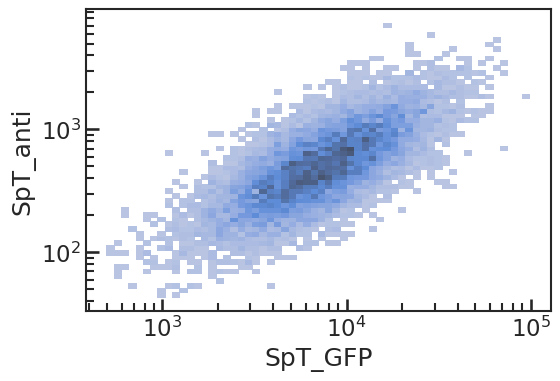

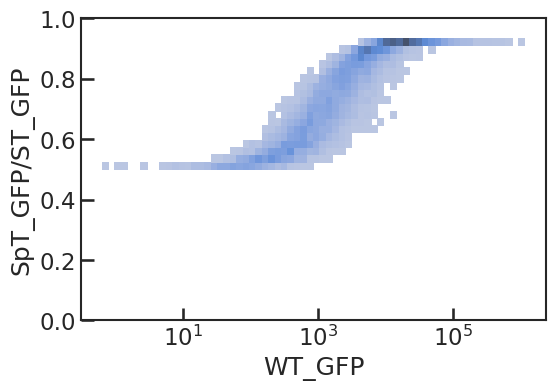

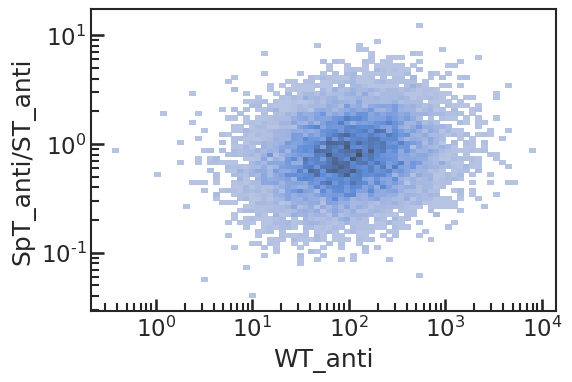

In [72]:
sns.histplot(df_syn, x='SpT_GFP', y='SpT_anti', log_scale=(True, True))

plt.show()


ax = sns.histplot(df_syn, x='WT_GFP', y='SpT_GFP/ST_GFP', log_scale=(True, False))
ax.set_ylim(0, 1.0)

plt.show()


ax = sns.histplot(df_syn, x='WT_anti', y='SpT_anti/ST_anti', log_scale=(True, True))

plt.show()

## Fit Model

Initial Loss: 0.573175010370304
Final Loss: -1.0555037788243378
Time Elapsed 1.3468689918518066 seconds
      fun: -1.0555037788243378
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.36875159e-08, -2.05415945e-07, -1.93715096e-07,  6.63101673e-06,
       -7.89761543e-06,  5.25504351e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 581
      nit: 66
     njev: 83
   status: 0
  success: True
        x: array([ 3.20502884e+00,  1.16066248e+00, -7.14210593e-03,  4.45560589e-02,
        6.99294686e-01, -1.00000000e-06])


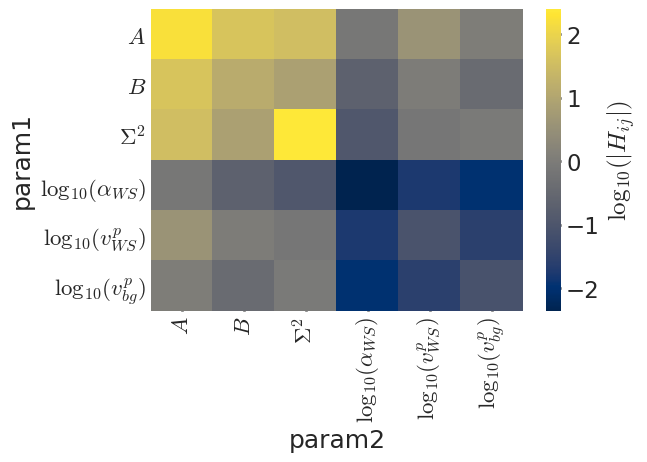

[5.64257031e-04 6.82329974e-03 6.53752485e-02 1.05124798e+00
 1.70718746e+02 2.63658419e+02]


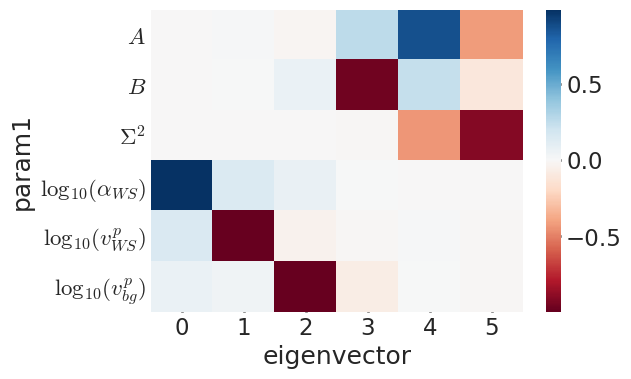

Fit values: 1603.3518730096096 14.47646344558648 0.9836891791722737 0.044556058855897585 0.6992946858544055 -1e-06
True values: 1500.0 13.0 1.0 0.045 0.7 0.0


In [73]:
push = ppamp.Push()
push.set_data(df_syn['WT_GFP'].values.copy(), df_syn['ST_GFP'].values.copy(), df_syn['SpT_anti'].values.copy())

noise_params, params = solve(push, verbose=True)

print("Fit values:", *params, *noise_params)
print("True values:", alphaWS, vWSp, vbgp, Sigma2, A, B)

## Plot Results

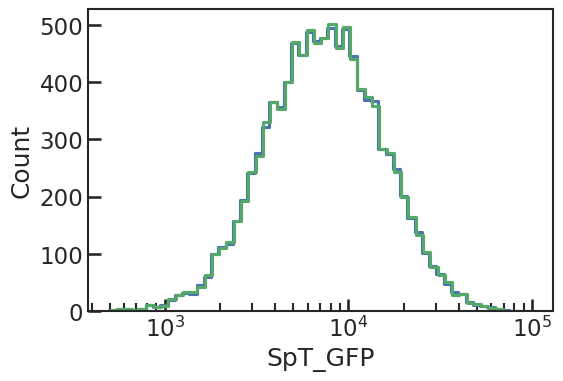

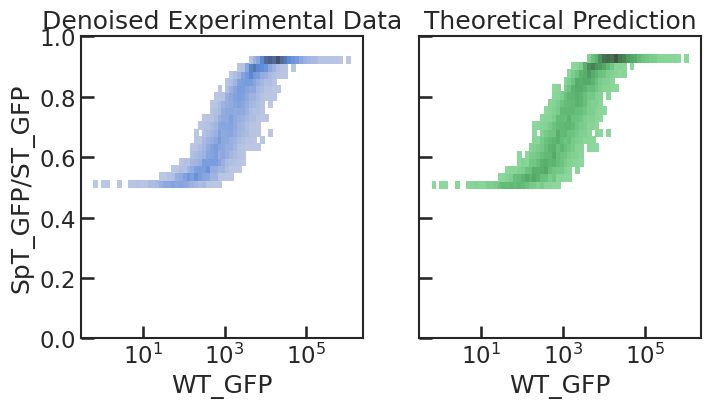

In [74]:
df_syn['SpT_GFP_predict'] = push.predict_all(params)
# df_syn['SpT_predict'] = push.predict_all(np.array([1300.0, 3333.3333333333335, 0.3333333333333333, 0.045, 0.7, 0.0]))

df_syn['SpT_GFP_predict/ST_GFP'] = df_syn['SpT_GFP_predict'] / df_syn['ST_GFP']


ax = sns.histplot(df_syn, x='SpT_GFP', log_scale=True, element="step", fill=False, label="True Values")
sns.histplot(df_syn, x='SpT_GFP_predict', log_scale=True, ax=ax, color='g', element="step", fill=False, label="Predicted Values")
plt.show()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

sns.histplot(df_syn, x='WT_GFP', y='SpT_GFP/ST_GFP', log_scale=(True, False), ax=ax1)
sns.histplot(df_syn, x='WT_GFP', y='SpT_GFP_predict/ST_GFP', log_scale=(True, False), color='g', ax=ax2)

ax1.set_ylim(0, 1.0)

ax1.set_title("Denoised Experimental Data")
ax2.set_title("Theoretical Prediction")

plt.show()



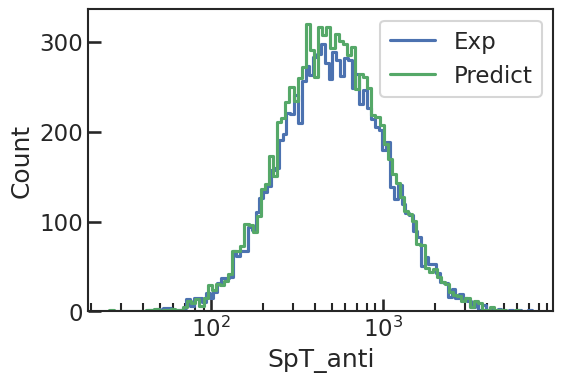

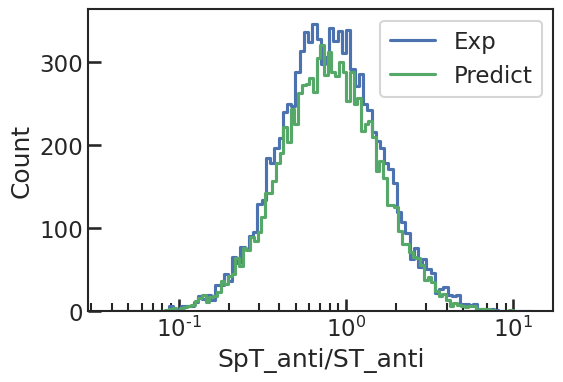

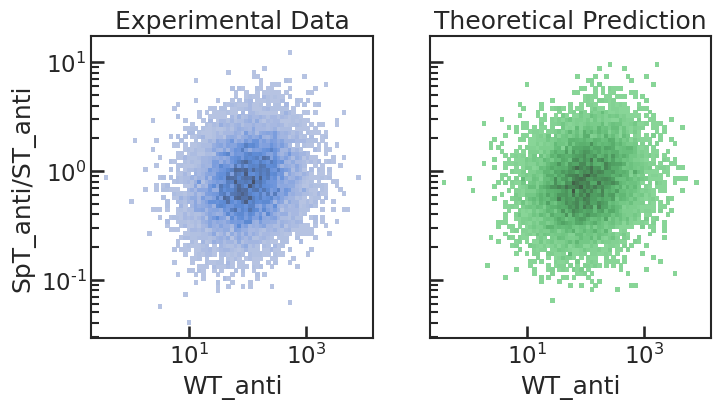

In [75]:
rand.seed(0)

(Sigma2, A, B) = noise_params

SpT_noise = noise.LogNormNoiseModel(Sigma2=noise_params[0], A=noise_params[1], B=noise_params[2])

df_syn['SpT_anti_predict'] = SpT_noise.GFP_to_anti(df_syn['SpT_GFP_predict'])

# 10**np.random.normal(A*np.log10(df_syn['SpT_GFP_predict'])+B, np.sqrt(Sigma2))

df_syn['SpT_anti_predict/ST_anti'] = df_syn['SpT_anti_predict'] / df_syn['ST_anti']


ax = sns.histplot(df_syn, x='SpT_anti', log_scale=True, element="step", fill=False, bins=100, label="Exp")
sns.histplot(df_syn, x='SpT_anti_predict', log_scale=True, ax=ax, color='g', element="step", fill=False, bins=100, label="Predict")

ax.legend()
plt.show()


ax = sns.histplot(df_syn, x='SpT_anti/ST_anti', log_scale=True, element="step", fill=False, bins=100, label="Exp")
sns.histplot(df_syn, x='SpT_anti_predict/ST_anti', log_scale=True, ax=ax, color='g', element="step", fill=False, bins=100, label="Predict")

ax.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

sns.histplot(df_syn, x='WT_anti', y='SpT_anti/ST_anti', log_scale=(True, True), ax=ax1)
sns.histplot(df_syn, x='WT_anti', y='SpT_anti_predict/ST_anti', log_scale=(True, True), color='g', ax=ax2)

ax1.set_title("Experimental Data")
ax2.set_title("Theoretical Prediction")


plt.show()





# Real Data

## Load Data

60038 / 60038


,WT_anti,ST_anti,SpT_anti,dataset,SpT_anti/ST_anti
1618,586.241028,3476.988525,3040.165527,u5,0.874367
11089,2069.620850,13184.651370,7717.164551,u60,0.585314
4447,4315.043945,6565.262695,47.988876,u5100,0.007310
14701,346.588348,1972.944458,54.483055,kinase_dead,0.027615
3967,692.999634,7800.176758,85.586166,u5,0.010972
...,...,...,...,...,...
1402,94.453537,2375.045898,136.801575,u30,0.057600
6090,143.309418,2200.200684,729.940369,u5,0.331761
3527,19764.214840,20852.832030,96.297897,kinase_dead,0.004618
3160,2984.329834,14200.054690,8218.972656,u60,0.578799


[[0.26619266 0.04967904]
 [0.04967904 0.61436733]]


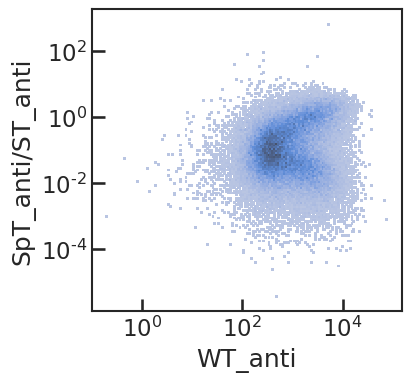

In [76]:
# df = pd.read_csv("../data/push/RR.csv")
# df = pd.read_csv("../data/push/EE(I).csv")
# df = pd.read_csv("../data/push/EE(L).csv")
# df = pd.read_csv("../data/push/EE(S).csv")
# df = pd.read_csv("../data/push/EE(E).csv")

df_list = []
df = pd.read_csv("../data/push/u5.csv")
df['dataset'] = 'u5'
df_list.append(df)
df = pd.read_csv("../data/push/u30.csv")
df['dataset'] = 'u30'
df_list.append(df)
df = pd.read_csv("../data/push/u60.csv")
df['dataset'] = 'u60'
df_list.append(df)
df = pd.read_csv("../data/push/u100.csv")
df['dataset'] = 'u5100'
df_list.append(df)
df = pd.read_csv("../data/push/Kinase Dead.csv")
df['dataset'] = 'kinase_dead'
df_list.append(df)

df = pd.concat(df_list)


df = df[(df[df.columns[:-1]] >= 0).all(axis=1)].rename(columns={'Kinase': 'WT_anti', 'Substrate': 'ST_anti', 'Phosphorylation': 'SpT_anti'})


df_sample = df.sample(frac=1.0, random_state=776)

df_sample['SpT_anti/ST_anti'] = df_sample['SpT_anti'] / df_sample['ST_anti']


print(len(df_sample.index), "/", len(df.index))

display(df_sample)

print(np.cov(np.log10(df_sample[['WT_anti', 'SpT_anti/ST_anti']].values.T)))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.histplot(df_sample, x='WT_anti', y='SpT_anti/ST_anti', log_scale=(True, True), ax=ax)

plt.show()


# fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# ax = sns.histplot(df_sample, x='ST_anti', y='SpT_anti', log_scale=(True, True), ax=ax)
# t = np.logspace(1, 4, base=10)
# ax.plot(t, t, 'k--')

# plt.show()



## Resample from Noise Models

,Flag Antibody,GFP - Area
0,187.686859,5196.793457
1,355.473175,9603.830078
2,41.772331,4211.423340
3,106.623306,586.752930
4,251.056992,17206.781250
...,...,...
22005,819.340881,26279.457030
22006,217.897446,5552.517090
22007,172.323105,3148.043213
22008,2958.141602,99144.625000


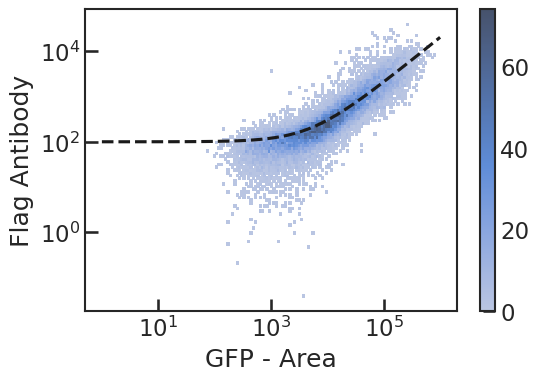

,Myc Antibody,GFP - Area
0,350.844482,3913.260498
1,1327.086426,14438.492190
2,833.156799,9002.547852
3,415.282654,3438.784180
4,260.497681,3944.230713
...,...,...
21933,88.697136,369.316315
21934,174.043274,3317.098389
21935,217.648987,2090.604736
21936,1159.802124,10384.017580


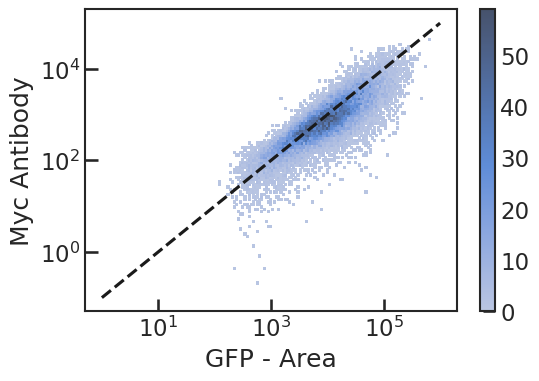

In [77]:
nbins_anti = 100
nbins_gfp = 100

# Writer

df_writer = pd.read_csv("../data/Kinase Noise.csv")
df_writer = df_writer[(df_writer[df_writer.columns] >= 0).all(axis=1)]

display(df_writer)

ax = sns.histplot(df_writer, x='GFP - Area', y='Flag Antibody', bins=(nbins_gfp, nbins_anti), 
             log_scale=(True, True), cbar=True)
t = np.logspace(0, 6, base=10)
ax.plot(t, 0.02*t+100, 'k--')

plt.show()

hist_writer, xedges_writer, yedges_writer = np.histogram2d(np.log10(df_writer['Flag Antibody']), np.log10(df_writer['GFP - Area']), bins=(nbins_anti, nbins_gfp))

# print(hist_writer)

df_sample['WT_anti_bin'] = pd.cut(df_sample['WT_anti'], bins=10**xedges_writer, labels=False)

# display(df_writer)

# Substrate

df_substrate = pd.read_csv("../data/Substrate Noise.csv")
df_substrate = df_substrate[(df_substrate[df_substrate.columns] >= 0).all(axis=1)]

display(df_substrate)

ax = sns.histplot(df_substrate, x='GFP - Area', y='Myc Antibody', bins=(nbins_gfp, nbins_anti), 
             log_scale=(True, True), cbar=True)
t = np.logspace(0, 6, base=10)
ax.plot(t, 0.1*t, 'k--')
plt.show()

hist_substrate, xedges_substrate, yedges_substrate = np.histogram2d(np.log10(df_substrate['Myc Antibody']), np.log10(df_substrate['GFP - Area']), bins=(nbins_anti, nbins_gfp))

# print(hist_writer)

df_sample['ST_anti_bin'] = pd.cut(df_sample['ST_anti'], bins=10**xedges_substrate, labels=False)


,WT_anti,ST_anti,SpT_anti,dataset,SpT_anti/ST_anti,WT_anti_bin,ST_anti_bin
0,586.241028,3476.988525,3040.165527,u5,0.874367,69.0,78.0
1,2069.620850,13184.651370,7717.164551,u60,0.585314,78.0,89.0
2,4315.043945,6565.262695,47.988876,u5100,0.007310,83.0,84.0
3,346.588348,1972.944458,54.483055,kinase_dead,0.027615,65.0,74.0
4,692.999634,7800.176758,85.586166,u5,0.010972,70.0,85.0
...,...,...,...,...,...,...,...
480299,94.453537,2375.045898,136.801575,u30,0.057600,56.0,75.0
480300,143.309418,2200.200684,729.940369,u5,0.331761,59.0,75.0
480301,19764.214840,20852.832030,96.297897,kinase_dead,0.004618,94.0,93.0
480302,2984.329834,14200.054690,8218.972656,u60,0.578799,81.0,90.0


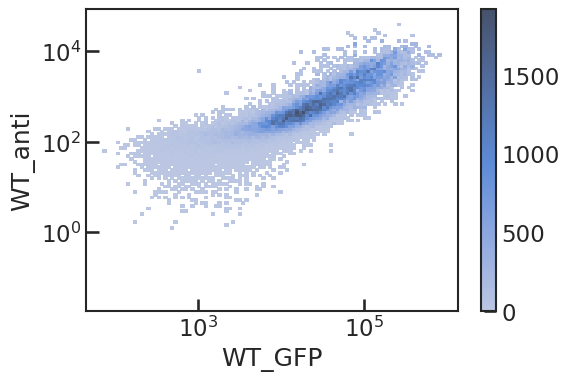

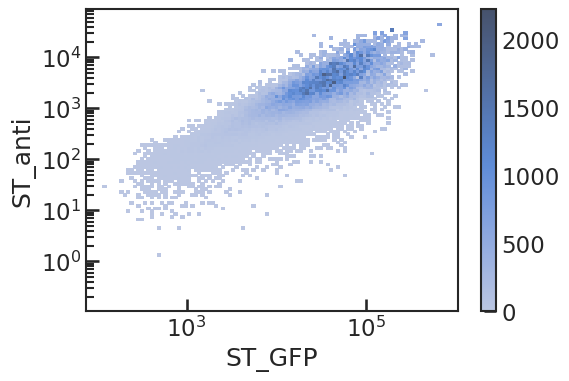

In [78]:
df_resample = pd.concat([df_sample for i in range(8)]).reset_index(drop=True)

display(df_resample)

df_resample['WT_GFP'] = -1

for WT_anti_bin, group in df_resample.groupby(['WT_anti_bin']):
#     print(WT_anti_bin)
    
    norm = np.sum(hist_writer[int(WT_anti_bin)])
    if norm > 0.0:
        p = hist_writer[int(WT_anti_bin)] / norm
    else:
        continue
        
    samples = rand.choice(10**((yedges_writer[:nbins_gfp]+yedges_writer[1:nbins_gfp+1])/2.0), size=len(group.index), p=p)
    # choice the bins numbers, then 
    
    df_resample.loc[group.index, 'WT_GFP'] = samples

df_resample['ST_GFP'] = -1
    
for ST_anti_bin, group in df_resample.groupby(['ST_anti_bin']):
#     print(ST_anti_bin)
    
    norm = np.sum(hist_substrate[int(ST_anti_bin)])
    
    if norm > 0.0:
        p = hist_substrate[int(ST_anti_bin)] / norm
    else:
        continue
    
    samples = rand.choice(10**((yedges_substrate[:nbins_gfp]+yedges_substrate[+1:nbins_gfp+1])/2.0), size=len(group.index), p=p)

    df_resample.loc[group.index, 'ST_GFP'] = samples

    
df_resample = df_resample[(df_resample['WT_GFP'] > 0) & (df_resample['ST_GFP'] > 0)] 


sns.histplot(df_resample, x='WT_GFP', y='WT_anti', bins=(yedges_writer, xedges_writer), 
             log_scale=(True, True), cbar=True)

plt.show()

sns.histplot(df_resample, x='ST_GFP', y='ST_anti', bins=(yedges_substrate, xedges_substrate), 
             log_scale=(True, True), cbar=True)


plt.show()


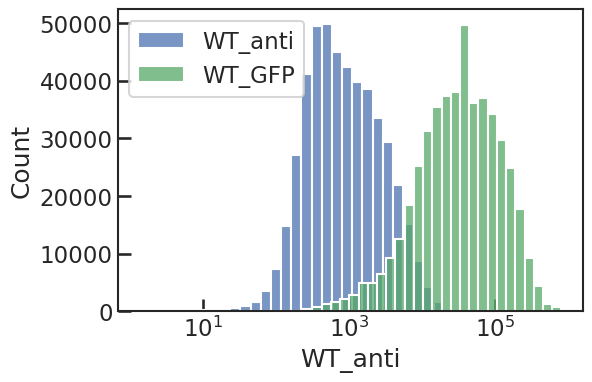

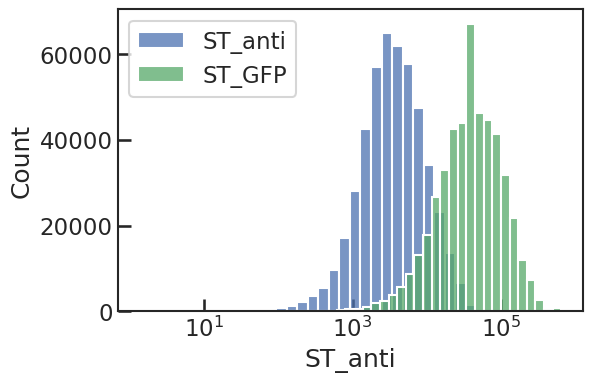

In [79]:
sns.histplot(df_resample, x='WT_anti', log_scale=True, label='WT_anti', bins=32)


ax = sns.histplot(df_resample, x='WT_GFP', log_scale=True, color='g', label='WT_GFP', bins=32)
ax.legend()
plt.show()

sns.histplot(df_resample, x='ST_anti', log_scale=True, label='ST_anti', bins=32)


ax = sns.histplot(df_resample, x='ST_GFP', log_scale=True, color='g', label='ST_GFP', bins=32)
ax.legend()
plt.show()

Initial Loss: 4.360700839320519
Final Loss: -0.014627365362859135
Time Elapsed 32.01708912849426 seconds
      fun: -0.014627365362859135
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.10822422e-07, -1.84029341e-06,  1.86330994e-06, -2.95788050e-06,
       -4.32133675e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 384
      nit: 43
     njev: 64
   status: 0
  success: True
        x: array([ 4.02882283,  0.03050569, -1.79735851,  0.3625371 ,  0.69471964])


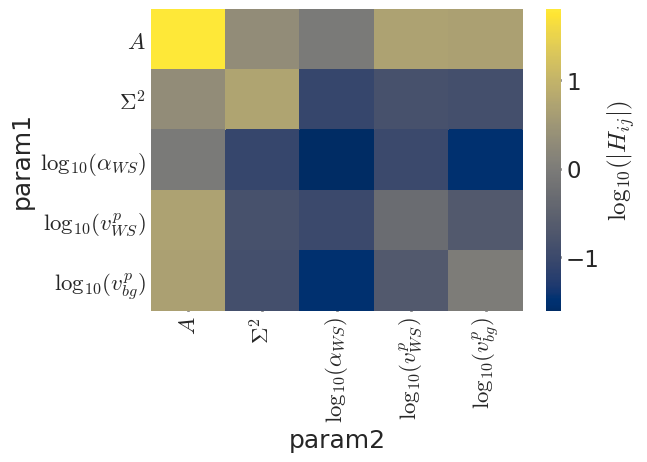

[6.40787784e+01 5.49303508e+00 7.22140297e-01 4.57587802e-02
 3.48937752e-03]


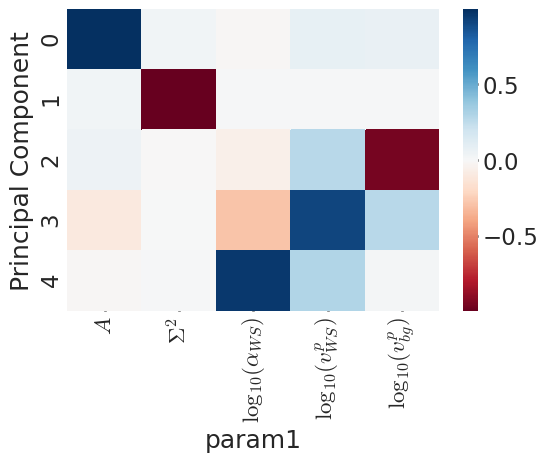

Fit values: 10686.18852268372 1.0727676988681039 0.015945622993899934 0.36253710305685666 0.6947196438386911


In [95]:
def solve(push, background, verbose=False):

    if verbose:
        start = time.time()

    def cpp_loss(x, args):
        
#         print(x)

        (logalphaWS, logvWSp, logvbgp, Sigma2, A) = x
        (push) = args

        loss = 0.0
        loss += push.loss(np.array([10**logalphaWS, 10**logvWSp, 10**logvbgp]), np.array([Sigma2, A, 0.0]))
        loss += background.loss(np.array([10**logvbgp]), np.array([Sigma2, A, 0.0]))
        
        return loss

    x0 = (3.0, 0.0, 0.0, 1.0, 1.0)
    # x0 = (1.0, 1.0, 1e-3)
    bounds = [(None, None), (None, None), (None, None), (1e-6, None), (0.0, None)]

    if verbose:
        print("Initial Loss:", cpp_loss(x0, (push)))


    res = opt.minimize(cpp_loss, x0, args=(push,), method='L-BFGS-B', jac='2-point', bounds=bounds, 
                       options={'iprint':101, 'eps': 1e-8, 'gtol': 1e-8, 'ftol':1e-12})
    

    params = 10**res.x[:3]
    noise_params = res.x[3:]

    if verbose:
        print("Final Loss:", res.fun)

        end = time.time()

        print("Time Elapsed", end-start, "seconds")

        print(res)
                
        hess = la.inv(res.hess_inv.todense())
        param_labels = [r"$\log_{10}(\alpha_{WS})$", r"$\log_{10}(v_{WS}^p)$", r"$\log_{10}(v_{bg}^p)$", r"$\Sigma^2$", r"$A$"]
        s_list = []
        
        for i, labeli in enumerate(param_labels):
            for j, labelj in enumerate(param_labels):
                s_list.append([labeli, labelj, np.log10(np.abs(hess[i, j]))])
        
        df = pd.DataFrame(s_list, columns=['param1', 'param2', 'hess'])
        sns.heatmap(df.pivot("param1", "param2", "hess"), cbar_kws={'label': r"$\log_{10}(|H_{ij}|)$"}, cmap='cividis', center=0)
        
        plt.show()
        
        evals, evecs = la.eigh(hess)
        
        evals = evals[::-1]
        evecs = evecs[:, ::-1]
        
        print(evals)
        
        s_list = []
        for i, labeli in enumerate(param_labels):
            for j in range(len(evals)):
                s_list.append([labeli, j, evecs[i, j]])
        
        df = pd.DataFrame(s_list, columns=['param1', 'Principal Component', 'val'])
        sns.heatmap(df.pivot("Principal Component", "param1", "val"), cmap='RdBu', center=0)
        
        plt.show()
        
    
    return noise_params, params


push = ppamp.Push()
df1 = df_resample.query("dataset!='kinase_dead'")
push.set_data(df1['WT_GFP'].values.copy(), df1['ST_GFP'].values.copy(), df1['SpT_anti'].values.copy())

background = ppamp.Background()
df2 = df_resample.query("dataset=='kinase_dead'")
background.set_data(df2['ST_GFP'].values.copy(), df2['SpT_anti'].values.copy())


noise_params, params = solve(push, background, verbose=True)

print("Fit values:", *params, *noise_params)


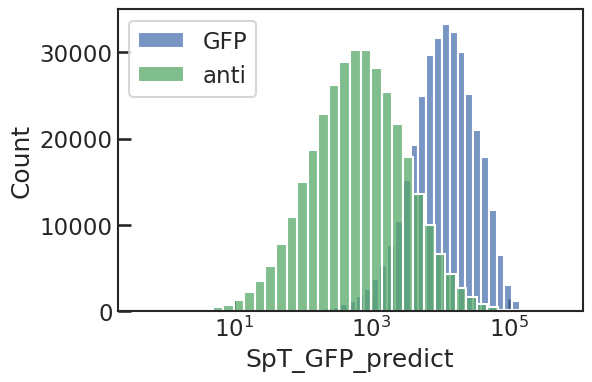

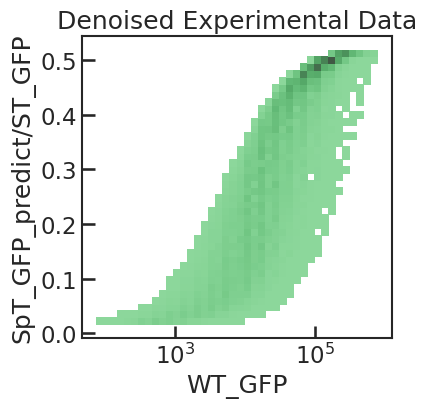

In [96]:
# params = np.array([1.0, 100.0, 0.00000000e+00, 2.81397600e-01, 0.7, 0.0])
# noise_params = params[3:]

df1 = df1.copy()

df1['SpT_GFP_predict'] = push.predict_all(params)
df1['SpT_GFP_predict/ST_GFP'] = df1['SpT_GFP_predict'] / df1['ST_GFP']

rand.seed(0)

(Sigma2, A) = noise_params

df1['SpT_anti_predict'] = 10**np.random.normal(A*np.log10(df1['SpT_GFP_predict']), np.sqrt(Sigma2))

df1['SpT_anti_predict/ST_anti'] = df1['SpT_anti_predict'] / df1['ST_anti']


ax = sns.histplot(df1, x='SpT_GFP_predict', log_scale=True, label="GFP", bins=40)

sns.histplot(df1, x='SpT_anti_predict', log_scale=True, color='g', label="anti", bins=40)


ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.histplot(df1, x='WT_GFP', y='SpT_GFP_predict/ST_GFP', log_scale=(True, False), color='g', ax=ax, bins=40)

# ax.set_ylim(0, 1.0)

ax.set_title("Denoised Experimental Data")

plt.show()



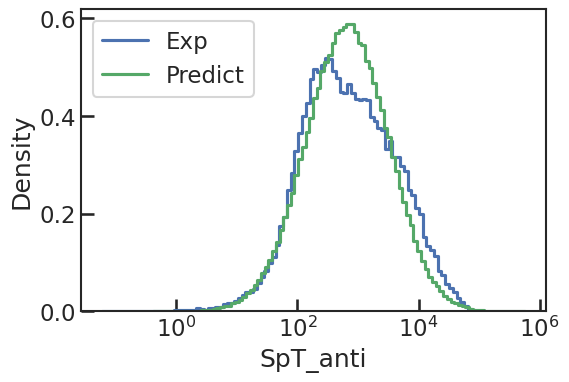

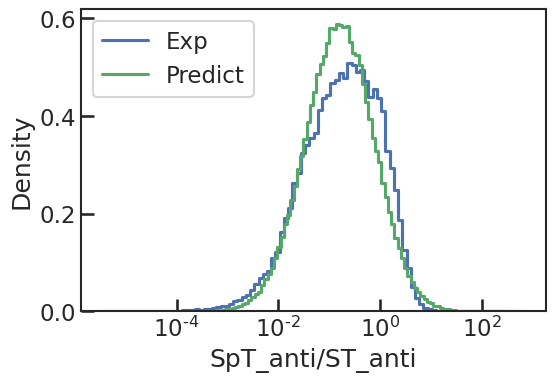

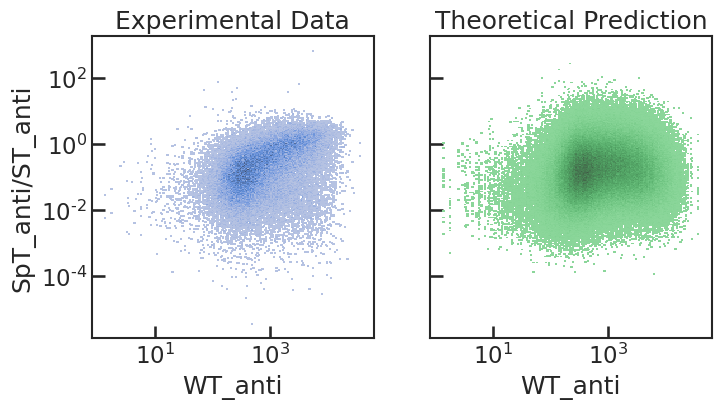

In [97]:



ax = sns.histplot(df1, x='SpT_anti', log_scale=True, element="step", fill=False, bins=100, label="Exp", 
                  stat='density')
sns.histplot(df1, x='SpT_anti_predict', log_scale=True, ax=ax, color='g', element="step", fill=False, bins=100, label="Predict", 
             stat='density')

ax.legend()
plt.show()


ax = sns.histplot(df1, x='SpT_anti/ST_anti', log_scale=True, element="step", fill=False, bins=100, label="Exp",
                 stat='density')
sns.histplot(df1, x='SpT_anti_predict/ST_anti', log_scale=True, ax=ax, color='g', element="step", fill=False, bins=100, label="Predict",
            stat='density')

ax.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

sns.histplot(df1, x='WT_anti', y='SpT_anti/ST_anti', log_scale=(True, True), ax=ax1)
sns.histplot(df1, x='WT_anti', y='SpT_anti_predict/ST_anti', log_scale=(True, True), color='g', ax=ax2)

# ax1.hlines(1.0, xmin=1e1, xmax=1e4, color='k', linestyle='--')

ax1.set_title("Experimental Data")
ax2.set_title("Theoretical Prediction")


plt.show()



